# Cross Entropy Method to solve Pendulum in OpenAI gym

This implementation reference to the psuedo code in the paper [Approximate Dynamic Programming Finally
Performs Well in the Game of Tetris](https://papers.nips.cc/paper/5190-approximate-dynamic-programming-finally-performs-well-in-the-game-of-tetris.pdf)
<img src="https://s8.postimg.cc/cmh2ex37p/Screen_Shot_2018-06-19_at_4.44.46_PM_1.png" width="700"/>

It use the noise function fomula from [Learning Tetris Using the Noisy Cross-Entropy Method](http://iew3.technion.ac.il/CE/files/papers/Learning%20Tetris%20Using%20the%20Noisy%20Cross-Entropy%20Method.pdf)

$Z_t = max(5 - t/10,0)$

## Breif Explanation

Cross Entropy Method is a evolutionary algorithm that perform optimization through searching in the parameter space. In this case here, we use $\theta$ to parameterize the policy such that $P_\theta(action|state)$, the algorithm as follow:
1. Generate a population of $\theta$ vectors
2. Measure the performance of each $\theta$ by running 10 simulation with the pendulum environment
3. Use the best performer to update the mean and standard deviation for each number in the $\theta$ vector
4. Repeat step 1 with the new mean and standard deviation until converge to a local minimum

Note that it does not calculate any gradient, it just shift the mean and standard deviation where high performing $\theta$ are being generated.

For more on cross entropy method or derivative free method in RL there is a [youtube video from Deep RL bootcamp](https://www.youtube.com/watch?v=SQtOI9jsrJ0) by Xi (Peter) Chen (UC Berkeley)

In [1]:
import numpy as np
from IPython import display
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import gym
import pickle

In [2]:
def noise():
  n = 5. - iteration / 10.
  return max(n, 0)

def get_sample_theta():
  theta = []
  n = noise()
  std_wNoise = std + n
  return np.random.normal(mean, std_wNoise)

def update_mean_std(theta_list):
  theta_all = np.stack(theta_list)
  mean = theta_all.mean(axis=0)
  std = theta_all.std(axis=0)
  std = np.minimum(std, 20)
  return (mean, std)

def get_action(state, theta):
  # input (1,3), first linear(dense) layer = (3,8) with relu
  out = np.dot(state, np.reshape(theta[:24],(3,8)))
  out = np.maximum(out, 0.0)
  # second layer 8,1 with tanh * 2.0 as Pendulum action space is -2.0 to 2.0
  out = np.dot(out, np.reshape(theta[24:],(8,1)))
  out = np.tanh(out) * 2.0
  return out

In [3]:
# parameters and initialization
theta_dim = 32
theta_population = 1000
mean = np.array([0] * theta_dim)
std = np.array([10] * theta_dim)
top_percentile = 0.1
roll_out_per_iter = 10
iteration = 0
theta_list = [get_sample_theta() for _ in range(theta_population)]
env = gym.make('Pendulum-v0')
statistic = {'avg_std':[], 'min_reward':[], 'max_reward':[], 'avg_reward':[]}

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [ ]:
while std.mean() > 3:
  reward_list = []
  # collect mean reward for each theta
  for theta in theta_list:
    mean_reward = 0
    for _ in range(roll_out_per_iter):
      state = env.reset()
      ended = False
      episode_reward = 0
      while not ended:
        action = get_action(state, theta)
        (state, reward, ended, info) = env.step(action)
        episode_reward += reward
      mean_reward += episode_reward / roll_out_per_iter
    reward_list.append(mean_reward)
    
  # use the top 10% of theta with highest reward to calculate the mean and standard deviation 
  rewards = np.array(reward_list)
  top_theta_indices = rewards.argsort()[-int(top_percentile * theta_population):]
  top_theta_list = [theta_list[i] for i in top_theta_indices]
  (mean, std) = update_mean_std(top_theta_list)
  
  # use the new mean and std to generate the next population of theta
  theta_list = [get_sample_theta() for _ in range(theta_population)]
  iteration += 1
  if iteration % 10 == 0:
    statistic['avg_std'].append(std.mean())
    statistic['min_reward'].append(min(reward_list))
    statistic['max_reward'].append(max(reward_list))
    statistic['avg_reward'].append(sum(reward_list) / len(reward_list))  
    print('i:%d, avg_std:%.2f, min: %.2f, max:%.2f, mean:%.2f' %(iteration, std.mean(), min(reward_list), max(reward_list), sum(reward_list) / len(reward_list)))
  # save progress
  pickle.dump(np.array(mean), open('cem_pendulum_mean.pkl', mode='wb'))
  pickle.dump(np.array(std), open('cem_pendulum_std.pkl', mode='wb'))


i:10, avg_std:20.00, min: -1834.71, max:-636.31, mean:-1474.33
i:20, avg_std:19.97, min: -1786.72, max:-416.82, mean:-1357.56
i:30, avg_std:19.19, min: -1577.91, max:-211.51, mean:-1150.61
i:40, avg_std:17.38, min: -1574.46, max:-140.68, mean:-800.41
i:50, avg_std:13.64, min: -1383.04, max:-84.73, mean:-391.76
i:60, avg_std:9.92, min: -724.64, max:-66.11, mean:-199.52
i:70, avg_std:8.28, min: -593.05, max:-77.50, mean:-168.36
i:80, avg_std:6.79, min: -610.45, max:-78.28, mean:-162.18
i:90, avg_std:5.97, min: -295.71, max:-67.95, mean:-156.26
i:100, avg_std:5.34, min: -329.55, max:-40.20, mean:-155.47


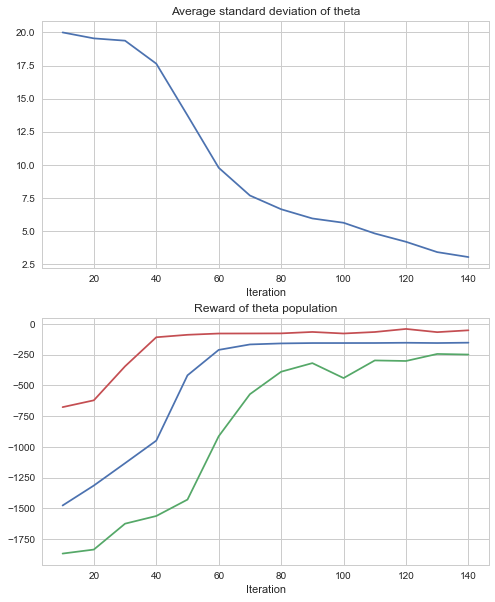

In [38]:
plt.figure(figsize=(8,10))
plt.subplot(211)
plt.title('Average standard deviation of theta')
plt.xlabel('Iteration')
plt.plot(range(10,150,10), statistic['avg_std'])
plt.subplot(212)
plt.title('Reward of theta population')
plt.xlabel('Iteration')
plt.plot(range(10,150,10), statistic['avg_reward'])
plt.plot(range(10,150,10), statistic['min_reward'])
plt.plot(range(10,150,10), statistic['max_reward'])

Above image shows the standard deviation of the population shrink over time as the performance of the $\theta$ population improve and converge to -250 to -50

In [166]:
# use the final mean as solution and run a sample episode
t = mean
state = env.reset()
frames = []
frames.append(env.render(mode='rgb_array'))
ended = False
while not ended:
  action = get_action(state, t)
  (state, reward, ended, info) = env.step(action)
  frames.append(env.render(mode='rgb_array'))

In [167]:
def animate(frames):
  fig, ax = plt.subplots()
  ax.grid('off')
  ax.axis('off')
  ims = []
  for i in range(len(frames)):
      im = plt.imshow(frames[i], animated=True)
      ims.append([im])
  ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
  return ani

In [168]:
%%capture
ani = animate(frames)
ani.save

In [169]:
HTML(ani.to_html5_video())